In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import seaborn as sns
from scipy import interpolate

In [3]:
plt.style.use('../paper/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

### calling in 10k merger tree realizations

### first the variance in the data

In [4]:
from scipy.stats import ks_2samp

def lnL_PNsat(data, model):
    lnL = np.sum(np.log(model.PNsat[data.Nsat_perhost]))
    if np.isinf(lnL):
        #print("index error in Pnsat")
        return -np.inf
    else:
        return lnL

def lnL_KS_max(data, model):
    try:
        clean_max_split = list(map(model.max_split.__getitem__, data.model_mask)) # this might yield an index error!
        p_vals = np.array(list(map(lambda x, y: ks_2samp(x, y)[1], data.clean_max_split, clean_max_split)))
        return np.sum(np.log(p_vals))
    except IndexError:
        #print("this model is not preferable!")
        return -np.inf

In [5]:
def measure_lnLvar_D(fid_theta=[10.5, 2.0, 0,0, 0.0, 0.2, 0.0], min_mass=6.5):

    lnLs = []
        
    for SAGA_ind in range(100):
        class_i = jsm_models.SAMPLE_CROSS(fid_theta, meta_path="../../../data/cross_host/lognorm_030_psi3/", SAGA_ind=SAGA_ind, verbose=False)
        Dstat_i = jsm_stats.SatStats_D(class_i.lgMs_data, min_mass, max_N=500)
        Mstat_i = jsm_stats.SatStats_M(class_i.lgMs_model, min_mass, max_N=500)

        lnL_i = lnL_PNsat(Dstat_i, Mstat_i) + lnL_KS_max(Dstat_i, Mstat_i)
        lnLs.append(lnL_i)

    lnLs  = np.array(lnLs)
    lnLs_clean = lnLs[~np.isinf(lnLs)]
    return lnLs_clean.std(ddof=1)

In [6]:
dvar_s30 = measure_lnLvar_D()

# dvar_s30 = 8.270528602243841


# now for the model

In [7]:
def measure_lnLvar_M(Nhost_per_model, SAGA_ind, fid_theta=[10.5, 2.0, 0,0, 0.0, 0.2, 0.0], min_mass=6.5):
    
    #print("selecting the", SAGA_ind, "SAGA index")    
    class_i = jsm_models.SAMPLE_CROSS(fid_theta, meta_path="../../../data/cross_host/lognorm_030_psi3/", SAGA_ind=SAGA_ind, verbose=False)
    Dstat_i = jsm_stats.SatStats_D(class_i.lgMs_data, min_mass, max_N=500)

    Nhost_extra = class_i.lgMs_model.shape[0] % Nhost_per_model
    if Nhost_extra == 0:
        N_models = int(class_i.lgMs_model.shape[0] / Nhost_per_model)
        class_i.lgMs_model = class_i.lgMs_model.reshape([N_models, Nhost_per_model, class_i.lgMs_model.shape[1]])
    else:
        class_i.lgMs_model = np.delete(class_i.lgMs_model, np.arange(Nhost_extra), axis=0)
        N_models = int(class_i.lgMs_model.shape[0] / Nhost_per_model)
        class_i.lgMs_model = class_i.lgMs_model.reshape([N_models, Nhost_per_model,  class_i.lgMs_model.shape[1]])

    # print("When Nhost = ", Nhost_per_model, ",there are", Nhost_extra, "extra trees. That leaves", N_models, "model realizations")
    # print(class_i.lgMs_model.shape)

    lnLs = []
    for model in class_i.lgMs_model:
        Mstat_i = jsm_stats.SatStats_M(model, min_mass, max_N=500)
        lnL_i = lnL_PNsat(Dstat_i, Mstat_i) + lnL_KS_max(Dstat_i, Mstat_i)
        lnLs.append(lnL_i)

    lnLs  = np.array(lnLs)
    lnLs_clean = lnLs[~np.isinf(lnLs)]
    return lnLs_clean.std(ddof=1)

In [8]:
Nhost = np.logspace(1.1,3, 25).astype(int)

var_mat = np.full((100, Nhost.shape[0]), np.nan)

for i,index in enumerate(range(100)):
    for j,Nmod in enumerate(Nhost):
        var_mat[i,j] = measure_lnLvar_M(Nhost_per_model=Nmod, SAGA_ind=index)

np.save("../../../paper_1/model_variance_15.npy", var_mat)

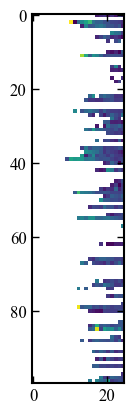

In [10]:
var_mat = np.load("../../../paper_1/model_variance_15.npy")
plt.imshow(var_mat)

In [11]:
Nhost_mat = np.tile(Nhost, (var_mat.shape[0], 1))

In [27]:
# x = np.log10(Nhost)
# y = np.nanmedian(var_mat, axis=0)

x = np.log10(Nhost_mat[~np.isnan(var_mat)])
y = var_mat[~np.isnan(var_mat)]

coefficients = np.polyfit(x,y, deg=1)
x_space = np.linspace(1, 4, 100)
y_fit = np.polyval(coefficients, x_space)

In [28]:
sigma_4 =  0 #y_fit[-1]
sigma_D = np.sqrt(dvar_s30**2 - sigma_4**2)

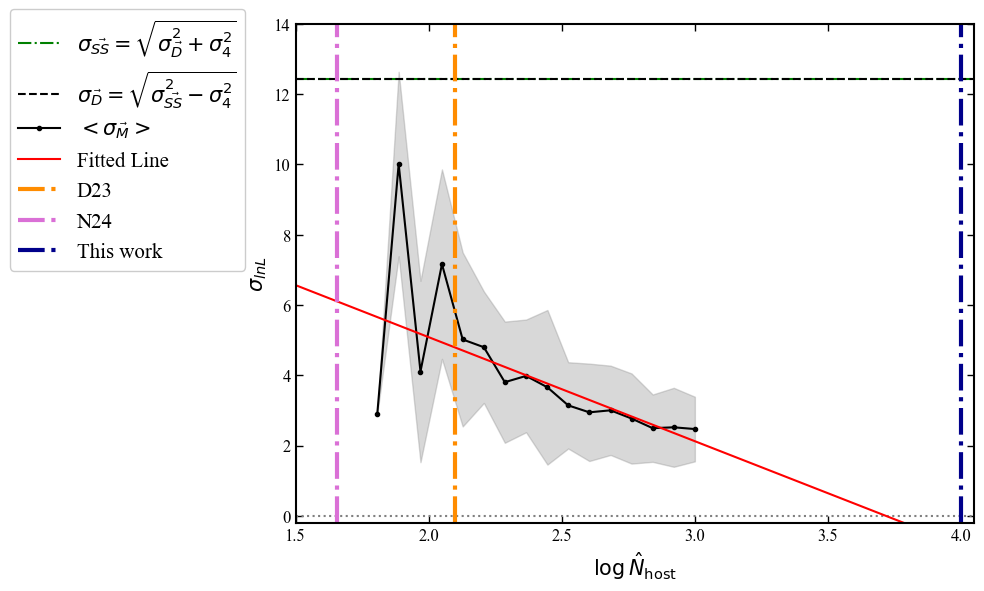

In [31]:
plt.figure(figsize=(10,6))
plt.axhline(dvar_s30, ls="-.", color="green", label="$\sigma_{\\vec{SS}} = \sqrt{ \sigma_{\\vec{D}}^2 + \sigma_{4}^2} $")
plt.axhline(sigma_D, ls="--", color="k", label="$\sigma_{\\vec{D}} = \sqrt{ \sigma_{\\vec{SS}}^2 - \sigma_{4}^2} $")
plt.axhline(0, color="grey", ls=":")

# for arr in var_mat:
#     plt.plot(np.log10(Nhost), arr, color="grey", alpha=0.1)


plt.fill_between(np.log10(Nhost), np.nanmean(var_mat, axis=0) - np.nanstd(var_mat, axis=0), np.nanmean(var_mat, axis=0) + np.nanstd(var_mat, axis=0), color="grey", alpha=0.3)
         
plt.plot(np.log10(Nhost), np.nanmean(var_mat, axis=0), color="k", marker=".", label="$< \sigma_{\\vec{M}} >$")
plt.plot(x_space, y_fit, color="red", label="Fitted Line")
#plt.axhline(2, color="red", label="by eye")

plt.axvline(np.log10(125), ls="-.", color="darkorange", lw=3, label="D23")
plt.axvline(np.log10(45), ls="-.", color="orchid", lw=3, label="N24")
plt.axvline(4, ls="-.", color="darkblue", lw=3, label="This work")



plt.legend(fontsize=15, loc=1, framealpha=1, bbox_to_anchor=(-0.06, 1.05))
plt.xlabel("$\log \hat{N}_{\mathrm{host}}$", fontsize=15)
plt.ylabel("$\sigma_{lnL}$", fontsize=15)

plt.xlim(1.5, 4.05)
plt.ylim(-0.2,14)

plt.tight_layout()
plt.savefig("../../../paper_1/figures/aux/convergence_s30.pdf", bbox_inches="tight")
plt.show()